In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
from IPython.display import display, HTML
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Create an empty DataFrame with the specified columns
results_df = pd.DataFrame(columns=["model", "rmse", "mae", "smape", "mase", "R2"])

STATION = 235
FREQ = '4w'
PERIOD = 13 # 13 weeks ARIMA
LOOK_BACK = 52 # 1 year
REMOVE_OUTLIERS = False


2023-04-09 22:46:56.352381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 22:46:56.469359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-09 22:46:56.469379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not 

# Functions

In [3]:
def get_specific_station_data(station, freq, filter_year = 1951):
    hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
    data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

    # Obtain dataset
    df = spark.read.parquet(data_files) \
            .withColumn("precipitation", col("precipitation").cast("float")) \
            .select("date","precipitation") \
            .toPandas()
    
    # Set the date column as the index and ensure it's a DatetimeIndex
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # Filter years
    df = df[df.index.year > filter_year] # Only 1951 onwards
    
    # Set the frequency data set
    df = df.resample(freq).mean()
    
    # drop null
    df.reset_index(inplace=True)
    df = df.dropna(axis=0)
    
    # set index
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df

def lstm_create_rnn(units, look_back, optimizer, activation='tanh', recurrent_activation='sigmoid', num_hidden_layers=3):
    model = Sequential()
    
    #Layer 1
    if((activation == None) & (recurrent_activation == None)):
        model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    elif(activation == None):
        model.add(LSTM(units, input_shape=(look_back, 1), recurrent_activation=recurrent_activation, return_sequences=True))
    elif(recurrent_activation == None):
        model.add(LSTM(units, input_shape=(look_back, 1), activation=activation, return_sequences=True))
    else:
        model.add(LSTM(units, input_shape=(look_back, 1), activation=activation, recurrent_activation=recurrent_activation, return_sequences=True))
        
    # Mid Layers
    for i in range(num_hidden_layers-2):
        if((activation == None) & (recurrent_activation == None)):
            model.add(LSTM(units, return_sequences=True))
        elif(activation == None):
            model.add(LSTM(units, recurrent_activation=recurrent_activation, return_sequences=True))
        elif(recurrent_activation == None):
            model.add(LSTM(units, activation=activation, return_sequences=True))
        else:
            model.add(LSTM(units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True))
    
    if(num_hidden_layers > 2):
        if((activation == None) & (recurrent_activation == None)):
            model.add(LSTM(units))
        elif(activation == None):
            model.add(LSTM(units, recurrent_activation=recurrent_activation))
        elif(recurrent_activation == None):
            model.add(LSTM(units, activation=activation))
        else:
            model.add(LSTM(units, activation=activation, recurrent_activation=recurrent_activation))


    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]



## Error functions definition

\begin{equation}
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
\end{equation}

\begin{equation}
\mathrm{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
\end{equation}

\begin{equation}
\text{SMAPE} = \frac{200}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|}
\end{equation}


\begin{equation}
\mathrm{MASE} = \frac{\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|}{\frac{1}{n-m}\sum_{i=m+1}^{n}|y_i - y_{i-m}|}
\end{equation}

\begin{equation}
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\end{equation}




In [4]:
def get_errors(test_y, predictions):
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    mae = mean_absolute_error(test_y, predictions)
    smape = 200 * np.mean(np.abs(test_y - predictions) / (np.abs(test_y) + np.abs(predictions)))
    mase = mae / np.mean(np.abs(test_y[1:] - test_y[:-1]))
    r_squared = r2_score(test_y, predictions)
      
    return (rmse, mae, smape, mase, r_squared)

In [5]:
# Create the RNN model with GRU units
def gru_create_model(units=50, look_back=26, activation="relu",num_hidden_layers=3, optimizer='adam'):
    model = Sequential()
    # Layer 1
    if((activation == None)):
        model.add(GRU(units=units, input_shape=(look_back, 1), return_sequences=True))
    else:
        model.add(GRU(units=units, activation=activation, input_shape=(look_back, 1), return_sequences=True))
    
    # Middle layers
    for i in range(num_hidden_layers-2):
        if((activation == None)):
            model.add(GRU(units=units, return_sequences=True))
        else:
            model.add(GRU(units=units, activation=activation, return_sequences=True))
    
    if(num_hidden_layers>2):
        if((activation == None)):
            model.add(GRU(units=units))
        else:
            model.add(GRU(units=units, activation=activation))
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Data

In [6]:
# Get data to test all models - remove extream weather conditions
daily_data = get_specific_station_data(STATION,'d',1800)
if(REMOVE_OUTLIERS):
    daily_data = remove_outlier(daily_data)

# Apply logaritmith differentiation for stationary data on the 12 weeks period
# daily_data["precipitation"] = np.log1p(daily_data["precipitation"])
# daily_data["precipitation"] = daily_data["precipitation"].diff()
    
data = daily_data.resample(FREQ).mean()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, LOOK_BACK)
test_X, test_y = create_sequences(test_data, LOOK_BACK)

# Reshape for RNN
rnn_train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
rnn_test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)


In [7]:
print("Raw Data (daily observations)")
print(get_specific_station_data(STATION,'d',1800).describe())
print("")
print("Daily Data (no outliers)")
print(daily_data.describe())
print("")
print("4w Data")
print(data.describe())

Raw Data (daily observations)
       precipitation
count   34951.000000
mean        2.310549
std         4.645792
min         0.000000
25%         0.000000
50%         0.100000
75%         2.600000
max        76.300003

Daily Data (no outliers)
       precipitation
count   34951.000000
mean        2.310549
std         4.645792
min         0.000000
25%         0.000000
50%         0.100000
75%         2.600000
max        76.300003

4w Data
       precipitation
count    1250.000000
mean        2.311995
std         1.432243
min         0.010714
25%         1.236607
50%         2.064286
75%         3.107143
max        10.253572


# LSTM

In [8]:
# Use best parameters
lstm_units = 26
lstm_look_back = LOOK_BACK
lstm_optimizer = Adam(learning_rate=0.001)
lstm_activation=None
lstm_recurrent_activation=None
lstm_num_hidden_layers=3
lstm_epochs = 30
lstm_batch_size = 5


# Create CNN model
lstm_model = lstm_create_rnn(units = lstm_units,
                   look_back = lstm_look_back,
                   optimizer = lstm_optimizer,
                   activation= lstm_activation,
                   recurrent_activation= lstm_recurrent_activation,
                   num_hidden_layers= lstm_num_hidden_layers
                )

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
lstm_model.fit(rnn_train_X, train_y, epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

lstm_predictions = lstm_model.predict(rnn_test_X)

2023-04-09 22:47:02.824053: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-09 22:47:02.824101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rmsryu-vm): /proc/driver/nvidia/version does not exist
2023-04-09 22:47:02.824933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
152/152 [==============================] - 10s 45ms/step - loss: 0.0187 - val_loss: 0.0251
Epoch 2/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0175 - val_loss: 0.0256
Epoch 3/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0172 - val_loss: 0.0242
Epoch 4/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0171 - val_loss: 0.0268
Epoch 5/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0163 - val_loss: 0.0230
Epoch 6/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0154 - val_loss: 0.0256
Epoch 7/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0154 - val_loss: 0.0223
Epoch 8/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0149 - val_loss: 0.0221
Epoch 9/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0147 - val_loss: 0.0218
Epoch 10/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0147 - val_l

In [9]:
# Calculate evaluation metrics
rmse, mae, smape, mase, r_squared = get_errors(test_y, lstm_predictions)

print("LSTM")
print(f"\tTest RMSE: {rmse:.5f}")
print(f"\tTest MAE: {mae:.5f}")
print(f"\tTest SMAPE: {smape:.5f}%")
print(f"\tTest MASE: {mase:.5f}")
print(f"\tTest R2: {r_squared:.5f}")

# Add to results
results_df.loc[0] = ["LSTM", rmse, mae, smape, mase, r_squared]

LSTM
	Test RMSE: 0.15749
	Test MAE: 0.11046
	Test SMAPE: 57.23680%
	Test MASE: 0.69861
	Test R2: 0.07387


# GRU

In [10]:
#precipitation = data.precipitation.values
#precipitation = scaler.fit_transform(precipitation.reshape(-1, 1))
precipitation = scaled_data

# Use best params
gru_units=50
gru_look_back = LOOK_BACK
gru_activation="relu"
gru_num_hidden_layers=3
gru_optimizer='adam'
gru_batch_size = 32
gru_epochs = 30

# Train the model
gru_model = gru_create_model(
    look_back=gru_look_back,
    activation=gru_activation,
    num_hidden_layers=gru_num_hidden_layers,
    optimizer=gru_optimizer)

gru_model.fit(rnn_train_X, train_y, epochs=gru_epochs, batch_size=gru_batch_size, verbose=1)

# Make predictions
gru_y_pred = gru_model.predict(test_X)

Epoch 1/30
30/30 [==============================] - 4s 47ms/step - loss: 0.0283
Epoch 2/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0188
Epoch 3/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0185
Epoch 4/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0184
Epoch 5/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0182
Epoch 6/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0184
Epoch 7/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0181
Epoch 8/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0181
Epoch 9/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0180
Epoch 10/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0180
Epoch 11/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0181
Epoch 12/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0177
Epoch 13/30
30/30 [==================

In [11]:
# Calculate evaluation metrics
rmse, mae, smape, mase, r_squared = get_errors(test_y, gru_y_pred)

print("GRU")
print(f"\tTest RMSE: {rmse:.5f}")
print(f"\tTest MAE: {mae:.5f}")
print(f"\tTest SMAPE: {smape:.5f}%")
print(f"\tTest MASE: {mase:.5f}")
print(f"\tTest R2: {r_squared:.5f}")

# Add to results
results_df.loc[1] = ["GRU", rmse, mae, smape, mase, r_squared]

GRU
	Test RMSE: 0.15576
	Test MAE: 0.10947
	Test SMAPE: 55.83097%
	Test MASE: 0.69235
	Test R2: 0.09411


# ARIMA

| Parameter | Value  | Description                                                                                   |
|-----------|--------|-----------------------------------------------------------------------------------------------|
| p         | 1      | The order of the autoregressive (AR) part of the model, denoting the number of lags to use.   |
| d         | 0      | The order of differencing, indicating the number of times the data is differenced.             |
| q         | 1      | The order of the moving average (MA) part of the model, representing the number of lagged errors to use. |
| s         | PERIOD | The seasonal period, which specifies the number of time steps in a season (13 weeks ).   |
| P         | 1      | The order of the seasonal autoregressive (SAR) part of the model, denoting the number of seasonal lags to use. |
| D         | 1      | The order of seasonal differencing, indicating the number of times the seasonal data is differenced. |
| Q         | 1      | The order of the seasonal moving average (SMA) part of the model, representing the number of lagged seasonal errors to use. |


In [12]:
# Best Params
p = 1
d = 0
q = 1
s = PERIOD  # Seasonal period (e.g., 12 weeks)
P = 1
D = 1
Q = 1

s_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
s_results = s_model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.46379D-01    |proj g|=  2.30849D+00


 This problem is unconstrained.



At iterate    5    f= -6.03094D-01    |proj g|=  5.92184D-01

At iterate   10    f= -6.15174D-01    |proj g|=  1.81211D-01

At iterate   15    f= -6.37374D-01    |proj g|=  1.11869D+00

At iterate   20    f= -6.46667D-01    |proj g|=  8.15450D-03

At iterate   25    f= -6.46671D-01    |proj g|=  1.94256D-02

At iterate   30    f= -6.46928D-01    |proj g|=  1.87976D-01

At iterate   35    f= -6.47237D-01    |proj g|=  9.29350D-03

At iterate   40    f= -6.47883D-01    |proj g|=  2.01990D-02

At iterate   45    f= -6.48152D-01    |proj g|=  7.00276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     54   

In [13]:
s_predictions = s_results.get_forecast(steps=len(test_data))
s_mean_predictions = s_predictions.predicted_mean[:test_y.shape[0]] # last ones in the array to match test_y array data

# Calculate evaluation metrics
rmse, mae, smape, mase, r_squared = get_errors(test_y, s_mean_predictions)

print("SARIMA")
print(f"\tTest RMSE: {rmse:.5f}")
print(f"\tTest MAE: {mae:.5f}")
print(f"\tTest SMAPE: {smape:.5f}%")
print(f"\tTest MASE: {mase:.5f}")
print(f"\tTest R2: {r_squared:.5f}")

# Add to results
results_df.loc[2] = ["SARIMA", rmse, mae, smape, mase, r_squared]

SARIMA
	Test RMSE: 0.15051
	Test MAE: 0.10898
	Test SMAPE: 46.65383%
	Test MASE: 0.68929
	Test R2: 0.15407


# ENSEMBEL MODELS

## ARIMA-GRU

ARIMA is clearly better capturing the trends, it performs better than the RNN ones. Let's try to use the residuals from the ARIMA model and use it to create a hybrid model with GRU

In [14]:
# By removing the fitted values in the Arima results we remove the seasonality of it
train_data_resid = train_data - s_results.fittedvalues
# For the test data we do the same with the predictions
test_data_resid = test_data - s_predictions.predicted_mean

h_X_train, h_y_train = create_sequences(train_data_resid, LOOK_BACK)
h_X_train = np.reshape(h_X_train, (h_X_train.shape[0], h_X_train.shape[1], 1))

# Train the model
gru_model_hybrid = gru_create_model(
    look_back=gru_look_back,
    activation=gru_activation,
    num_hidden_layers=gru_num_hidden_layers,
    optimizer=gru_optimizer)

gru_model_hybrid.fit(h_X_train, h_y_train, epochs=gru_epochs, batch_size=gru_batch_size, verbose=1)

# Get predictions 
h_predictions_gru = gru_model_hybrid.predict(rnn_test_X) 

# Combine with Arima
s_mean_predictions_trimmed = s_mean_predictions[-h_predictions_gru.shape[0]:]
h_predictions_combined = s_mean_predictions_trimmed + h_predictions_gru.flatten()

# Remove bias from the training. This needs further investatigation
h_predictions_combined = h_predictions_combined - np.mean(train_data.flatten()) 


Epoch 1/30
30/30 [==============================] - 4s 47ms/step - loss: 0.0319
Epoch 2/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0183
Epoch 3/30
30/30 [==============================] - 1s 45ms/step - loss: 0.0184
Epoch 4/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0183
Epoch 5/30
30/30 [==============================] - 1s 49ms/step - loss: 0.0183
Epoch 6/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0182
Epoch 7/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0185
Epoch 8/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0182
Epoch 9/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0181
Epoch 10/30
30/30 [==============================] - 1s 46ms/step - loss: 0.0180
Epoch 11/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0178
Epoch 12/30
30/30 [==============================] - 1s 47ms/step - loss: 0.0176
Epoch 13/30
30/30 [==================

In [15]:
# Calculate evaluation metrics
rmse, mae, smape, mase, r_squared = get_errors(test_y, h_predictions_combined)

print("ARIMA-GRU")
print(f"\tTest RMSE: {rmse:.5f}")
print(f"\tTest MAE: {mae:.5f}")
print(f"\tTest SMAPE: {smape:.5f}%")
print(f"\tTest MASE: {mase:.5f}")
print(f"\tTest R2: {r_squared:.5f}")

# Add to results
results_df.loc[3] = ["ARIMA-GRU", rmse, mae, smape, mase, r_squared]

ARIMA-GRU
	Test RMSE: 0.15882
	Test MAE: 0.11599
	Test SMAPE: 48.06672%
	Test MASE: 0.73357
	Test R2: 0.05812


## ARIMA-LSTM

In [16]:
# By removing the fitted values in the Arima results we remove the seasonality of it
train_data_resid = train_data - s_results.fittedvalues
# For the test data we do the same with the predictions
test_data_resid = test_data - s_predictions.predicted_mean

hLSTM_X_train, hLSTM_y_train = create_sequences(train_data_resid, LOOK_BACK)
hLSTM_X_train = np.reshape(hLSTM_X_train, (hLSTM_X_train.shape[0], hLSTM_X_train.shape[1], 1))

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
lstm_model.fit(hLSTM_X_train, hLSTM_X_train, epochs=lstm_epochs, batch_size=lstm_batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Get predictions 
h_predictions_lstm = lstm_model.predict(rnn_test_X) 

# Combine with Arima
s_mean_predictions_trimmed = s_mean_predictions[-h_predictions_lstm.shape[0]:]
hLSTM_predictions_combined = s_mean_predictions_trimmed + h_predictions_lstm.flatten()

# Remove bias from the training. This needs further investatigation
hLSTM_predictions_combined = hLSTM_predictions_combined - np.mean(train_data.flatten()) 


Epoch 1/30
152/152 [==============================] - 9s 47ms/step - loss: 0.0169 - val_loss: 0.0243
Epoch 2/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0166 - val_loss: 0.0241
Epoch 3/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0166 - val_loss: 0.0239
Epoch 4/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0166 - val_loss: 0.0238
Epoch 5/30
152/152 [==============================] - 6s 40ms/step - loss: 0.0166 - val_loss: 0.0239
Epoch 6/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0166 - val_loss: 0.0235
Epoch 7/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0165 - val_loss: 0.0231
Epoch 8/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0163 - val_loss: 0.0231
Epoch 9/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0163 - val_loss: 0.0230
Epoch 10/30
152/152 [==============================] - 6s 41ms/step - loss: 0.0163 - val_lo

In [17]:
# Calculate evaluation metrics
rmse, mae, smape, mase, r_squared = get_errors(test_y, hLSTM_predictions_combined)

print("ARIMA-LSTM")
print(f"\tTest RMSE: {rmse:.5f}")
print(f"\tTest MAE: {mae:.5f}")
print(f"\tTest SMAPE: {smape:.5f}%")
print(f"\tTest MASE: {mase:.5f}")
print(f"\tTest R2: {r_squared:.5f}")

# Add to results
results_df.loc[4] = ["ARIMA-LSTM", rmse, mae, smape, mase, r_squared]

ARIMA-LSTM
	Test RMSE: 0.15264
	Test MAE: 0.11556
	Test SMAPE: 48.29067%
	Test MASE: 0.73088
	Test R2: 0.12997


# Plot results

In [18]:
test_data[:150].shape

(150, 1)

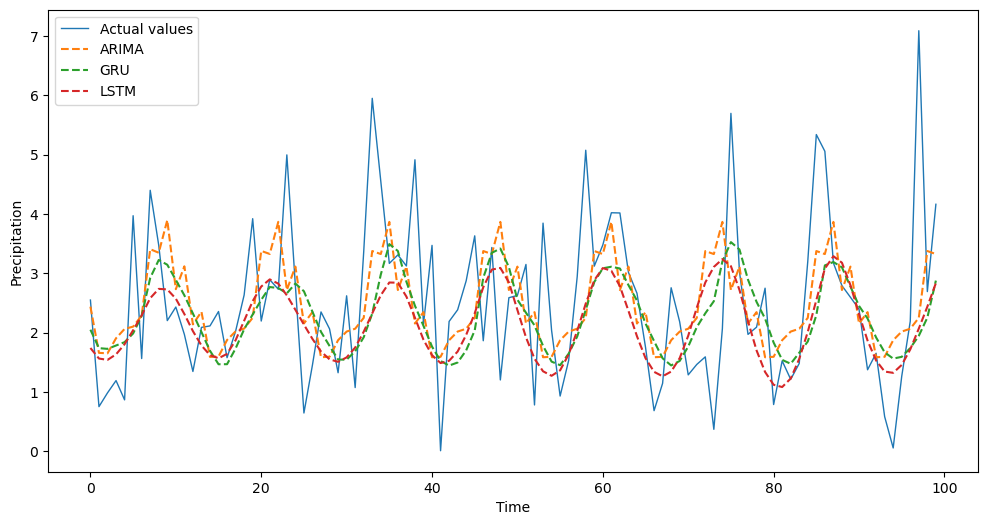

In [19]:
plt.figure(figsize=(12, 6))
zoom = 100
#plt.plot(train_data, label='Training Data')
plt.plot(scaler.inverse_transform(test_data)[:zoom], label='Actual values', linewidth=1)
plt.plot(scaler.inverse_transform(s_mean_predictions.reshape(-1, 1))[:zoom], label='ARIMA', linestyle='dashed')
plt.plot(scaler.inverse_transform(gru_y_pred)[:zoom], label='GRU', linestyle='dashed')
plt.plot(scaler.inverse_transform(lstm_predictions)[:zoom], label='LSTM', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


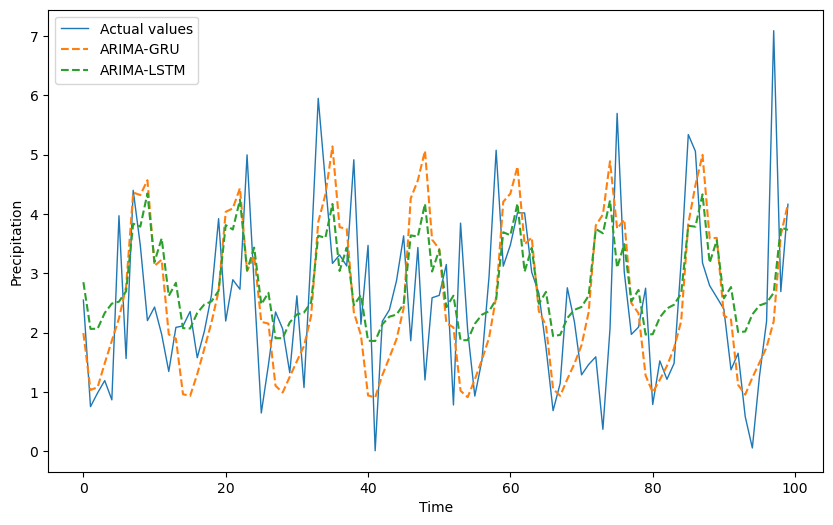

In [20]:
plt.figure(figsize=(10, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(scaler.inverse_transform(test_data)[:zoom], label='Actual values', linewidth=1)
plt.plot(scaler.inverse_transform(h_predictions_combined.reshape(-1, 1))[:zoom], label='ARIMA-GRU', linestyle='dashed')
plt.plot(scaler.inverse_transform(hLSTM_predictions_combined.reshape(-1, 1))[:zoom], label='ARIMA-LSTM', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

In [21]:
results_df.sort_values("R2",ascending=False)

,model,rmse,mae,smape,mase,R2
2,SARIMA,0.150514,0.108984,46.653828,0.689285,0.154068
4,ARIMA-LSTM,0.152643,0.115560,48.290665,0.730881,0.129974
1,GRU,0.155757,0.109468,55.830967,0.692346,0.094107
0,LSTM,0.157487,0.110458,57.236797,0.698608,0.073868
3,ARIMA-GRU,0.158821,0.115985,48.066722,0.733568,0.058118


In [22]:
results_df.to_markdown()

'|    | model      |     rmse |      mae |   smape |     mase |        R2 |\n|---:|:-----------|---------:|---------:|--------:|---------:|----------:|\n|  0 | LSTM       | 0.157487 | 0.110458 | 57.2368 | 0.698608 | 0.073868  |\n|  1 | GRU        | 0.155757 | 0.109468 | 55.831  | 0.692346 | 0.0941067 |\n|  2 | SARIMA     | 0.150514 | 0.108984 | 46.6538 | 0.689285 | 0.154068  |\n|  3 | ARIMA-GRU  | 0.158821 | 0.115985 | 48.0667 | 0.733568 | 0.0581182 |\n|  4 | ARIMA-LSTM | 0.152643 | 0.11556  | 48.2907 | 0.730881 | 0.129974  |'

#  RESULTS

## 1: 12 weeks look-back
- Stationary transformation: None
- STATION = 235
- FREQ = '4w'
- PERIOD = 13 # 3 weeks
- LOOK_BACK = 12 # or 3 months
- REMOVE_OUTLIERS = False

|    | model      |     rmse |      mae |   smape |     mase |         R2 |
|---:|:-----------|---------:|---------:|--------:|---------:|-----------:|
|  0 | LSTM       | 0.150469 | 0.110279 | 50.6049 | 0.725921 |  0.0756365 |
|  2 | SARIMA     | 0.150587 | 0.110299 | 46.7615 | 0.726046 |  0.0741875 |
|  1 | GRU        | 0.15251  | 0.110118 | 52.5891 | 0.724859 |  0.0503955 |
|  3 | ARIMA-GRU  | 0.153765 | 0.11379  | 47.5217 | 0.749027 |  0.0346935 |
|  4 | ARIMA-LSTM | 0.158312 | 0.12002  | 49.2976 | 0.790035 | -0.0232413 |

## 2: 24 weeks look-back
- Stationary transformation: None
- STATION = 235
- FREQ = '4w'
- PERIOD = 26 # 26 weeks
- LOOK_BACK = 26 # or 6+ months
- REMOVE_OUTLIERS = False

|    | model      |     rmse |      mae |   smape |     mase |         R2 |
|---:|:-----------|---------:|---------:|--------:|---------:|-----------:|
|  1 | GRU        | 0.15101  | 0.107687 | 54.6601 | 0.693577 |  0.101319  |
|  2 | SARIMA     | 0.151082 | 0.110584 | 47.1171 | 0.712229 |  0.100464  |
|  4 | ARIMA-LSTM | 0.155773 | 0.117122 | 48.1736 | 0.754344 |  0.0437311 |
|  0 | LSTM       | 0.156412 | 0.112076 | 53.5987 | 0.72184  |  0.0358735 |
|  3 | ARIMA-GRU  | 0.160958 | 0.114803 | 50.2507 | 0.739405 | -0.0209833 |


## 3: 52 weeks look-back
- Stationary transformation: None
- STATION = 235
- FREQ = '4w'
- PERIOD = 52 # 1 year
- LOOK_BACK = 52 # 1 year
- REMOVE_OUTLIERS = False


|    | model      |     rmse |      mae |   smape |     mase |          R2 |
|---:|:-----------|---------:|---------:|--------:|---------:|------------:|
|  0 | LSTM       | 0.152468 | 0.108222 | 55.9151 | 0.684471 | 0.131958    |
|  1 | GRU        | 0.156232 | 0.11037  | 55.1029 | 0.698052 | 0.088576    |
|  4 | ARIMA-LSTM | 0.158288 | 0.113826 | 48.0972 | 0.719913 | 0.0644262   |
|  2 | SARIMA     | 0.158956 | 0.114872 | 48.7609 | 0.726529 | 0.0565108   |
|  3 | ARIMA-GRU  | 0.163579 | 0.11716  | 49.1714 | 0.740998 | 0.000835634 |

## 4: 52 weeks RNN and 13 weeks ARIMA

- Stationary transformation: None
- STATION = 235
- FREQ = '4w'
- PERIOD = 13 # weeks
- LOOK_BACK = 52 # 1 year
- REMOVE_OUTLIERS = False

|    | model      |     rmse |      mae |   smape |     mase |        R2 |
|---:|:-----------|---------:|---------:|--------:|---------:|----------:|
|  2 | SARIMA     | 0.150514 | 0.108984 | 46.6538 | 0.689285 | 0.154068  |
|  4 | ARIMA-LSTM | 0.151674 | 0.114151 | 47.9172 | 0.721967 | 0.140975  |
|  0 | LSTM       | 0.152592 | 0.109623 | 55.4187 | 0.693331 | 0.130553  |
|  1 | GRU        | 0.156029 | 0.108697 | 56.4867 | 0.687473 | 0.0909367 |
|  3 | ARIMA-GRU  | 0.158498 | 0.115837 | 47.8536 | 0.732629 | 0.0619464 |


## 5: 156 weeks RNN 13 weeks ARIMA

- Stationary transformation: None
- STATION = 235
- FREQ = '4w'
- PERIOD = 13 # weeks
- LOOK_BACK = 156 # 3 year
- REMOVE_OUTLIERS = False

|    | model      |     rmse |      mae |   smape |     mase |        R2 |
|---:|:-----------|---------:|---------:|--------:|---------:|----------:|
|  2 | SARIMA     | 0.167313 | 0.117635 | 48.9923 | 0.639635 | 0.103511  |
|  4 | ARIMA-LSTM | 0.167772 | 0.117407 | 48.9614 | 0.638396 | 0.0985924 |
|  0 | LSTM       | 0.171044 | 0.117494 | 56.8323 | 0.638869 | 0.0630822 |
|  3 | ARIMA-GRU  | 0.174324 | 0.124827 | 51.4687 | 0.678739 | 0.0268058 |
|  1 | GRU        | 0.175363 | 0.121455 | 55.3411 | 0.660403 | 0.0151701 |


## Plot results

In [34]:
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

data = {
    'model': ['LSTM', 'SARIMA', 'GRU', 'ARIMA-GRU', 'ARIMA-LSTM'],
    '12 weeks': [0.0756365, 0.0741875, 0.0503955, 0.0346935, -0.0232413],
    '26 weeks': [0.0358735, 0.100464, 0.101319, -0.0209833, 0.0437311],
    '52 weeks': [0.131958, 0.0565108, 0.088576, 0.000835634, 0.0644262],
    '52rnn13A': [0.130553, 0.154068, 0.0909367, 0.0619464, 0.140975],
    '156rnn13wA': [0.0630822, 0.103511, 0.0151701, 0.0268058, 0.0985924]
}

# Create a dataframe from the data
df = pd.DataFrame(data)

# Find the unique time periods and models
time_periods = df.columns[1:]
models = df['model'].unique()

# Create a line plot for each model
fig = go.Figure()

for model in models:
    model_data = df[df['model'] == model]
    fig.add_trace(go.Scatter(x=time_periods,
                             y=model_data.iloc[0, 1:].values,
                             mode='lines+markers',
                             name=model))

# Customize the layout
fig.update_layout(title='Model Performance test runs',
                  xaxis_title='Time Period',
                  yaxis_title='Value')

# Show the plot
fig.show()